In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import math
from collections import defaultdict
import csv
import pandas as pd
import numpy as np
from flask import jsonify
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.externals import joblib
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
data = pd.read_csv('house_prediction/data/output copy.csv')

# Separate out the x_data and y_data.
data_X = data.loc[:, [col for col in data.columns if col not in ["price_sqft","address","url","price"]]]
data_y = data.loc[:, "price"]
print data_X

       latitude  longitude     city state  postal_code  #bedrooms  #bathrooms  \
0     33.819490 -84.360390  Atlanta    GA        30324          1         1.0   
1     33.913258 -84.451048  Atlanta    GA        30339          5         7.0   
2     33.776355 -84.356698  Atlanta    GA        30306          3         2.5   
3     33.846274 -84.291759  Atlanta    GA        30345          5         6.0   
4     33.872562 -84.376167  Atlanta    GA        30342          6         6.0   
5     33.776355 -84.356698  Atlanta    GA        30306          6         5.0   
6     33.872561 -84.376171  Atlanta    GA        30342          6         5.5   
7     33.875643 -84.358527  Atlanta    GA        30342          5         5.0   
8     33.802027 -84.394492  Atlanta    GA        30309          4         4.0   
9     33.820070 -84.340721  Atlanta    GA        30324          4         4.0   
10    33.783563 -84.335497  Atlanta    GA        30307          5         4.0   
11    33.777434 -84.379440  

In [4]:
""" about label encoder
#https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
# Encoding the variable
fit = df.apply(lambda x: d[x.name].fit_transform(x))
# Inverse the encoded
fit.apply(lambda x: d[x.name].inverse_transform(x))
# Using the dictionary to label future data
df.apply(lambda x: d[x.name].transform(x))
"""
encode_list = ['city','state']
d = defaultdict(LabelEncoder)
data_X_encoded = data_X.apply(lambda x: d[x.name].fit_transform(x) if x.name in encode_list else x)
print data_X_encoded

       latitude  longitude  city  state  postal_code  #bedrooms  #bathrooms  \
0     33.819490 -84.360390     0      0        30324          1         1.0   
1     33.913258 -84.451048     0      0        30339          5         7.0   
2     33.776355 -84.356698     0      0        30306          3         2.5   
3     33.846274 -84.291759     0      0        30345          5         6.0   
4     33.872562 -84.376167     0      0        30342          6         6.0   
5     33.776355 -84.356698     0      0        30306          6         5.0   
6     33.872561 -84.376171     0      0        30342          6         5.5   
7     33.875643 -84.358527     0      0        30342          5         5.0   
8     33.802027 -84.394492     0      0        30309          4         4.0   
9     33.820070 -84.340721     0      0        30324          4         4.0   
10    33.783563 -84.335497     0      0        30307          5         4.0   
11    33.777434 -84.379440     0      0        30308

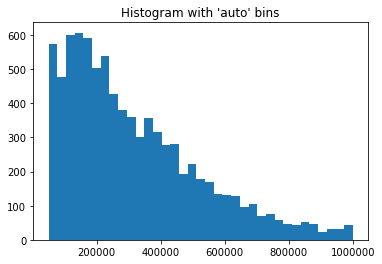

In [5]:
#print d

import matplotlib.pyplot as plt
#rng = np.random.RandomState(10)  # deterministic random data
#a = np.hstack((rng.normal(size=1000),
#               rng.normal(loc=5, scale=2, size=1000)))
plt.hist(data_y, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
#plt.set_xscale('log')
plt.show()

In [6]:
rf_model = RandomForestRegressor(n_estimators=100, criterion='mse',\
                                 max_depth=10, min_samples_split=2, min_samples_leaf=1, \
                                 min_weight_fraction_leaf=0.0, max_features='auto', \
                                 max_leaf_nodes=None, min_impurity_decrease=0.0, \
                                 min_impurity_split=None, bootstrap=True, oob_score=False, \
                                 n_jobs=1, random_state=None, verbose=0, warm_start=False)

from sklearn.metrics import fbeta_score, make_scorer

def my_custom_loss_func(ground_truth, predictions):
    diff = -np.abs((ground_truth - predictions)/ground_truth).mean()
    return diff
my_scorer = make_scorer(my_custom_loss_func, greater_is_better=True)
cv_para = ShuffleSplit(n_splits=10, test_size=0.1, random_state=100)
print 'cross validation score of rf_model: '+str(cross_val_score(rf_model, data_X_encoded, data_y,
                                                                 cv=cv_para, scoring=my_scorer))


cross validation score of rf_model: [-0.26451046 -0.22208694 -0.25342337 -0.22581002 -0.25473754 -0.24074962
 -0.24750567 -0.25055304 -0.23373598 -0.2368305 ]


In [7]:
parameters = {'n_estimators':[50,100,150],'max_depth':[10,15,20],
'max_features':['auto','sqrt','log2'],'min_samples_split':[2,10,20]}
clf = GridSearchCV(rf_model, parameters,scoring=my_scorer,cv=cv_para,verbose=30,n_jobs=3)
clf.fit(data_X_encoded,data_y)
print ("rf best para:",clf.best_params_)
print ("rf best score:",clf.best_score_)
print ("results",clf.cv_results_)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10 
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10 
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10 
[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.254565431422, total=   6.0s
[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.267934554221, total=   6.0s
[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.220834133109, total=   6.0s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10 
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10 
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    6.2s
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:    6.2s


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.242135610806, total=   5.9s
[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.256820301731, total=   5.9s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10 
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10 
[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.225851650006, total=   6.0s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:   12.1s
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:   12.1s
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:   12.2s


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.248738540771, total=   6.0s
[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.251311088976, total=   6.0s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10 
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10 
[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.233118382383, total=   6.0s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   18.3s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:   18.3s
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:   18.3s


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.236730323439, total=   6.6s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:   25.0s


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.265748667927, total=  13.2s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10 
[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.221150016396, total=  13.3s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:   31.6s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   31.7s


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.254589212967, total=  13.8s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:   39.0s


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.227540685737, total=  13.0s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10 
[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.255089452231, total=  13.2s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:   44.9s
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:   45.1s


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.239649263206, total=  11.7s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  16 tasks      | elapsed:   50.8s


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.243499681662, total=  11.4s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10 
[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.250738257969, total=  11.3s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  17 tasks      | elapsed:   56.5s
[Parallel(n_jobs=3)]: Done  18 tasks      | elapsed:   56.6s


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.23364827278, total=  11.4s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  1.0min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.234929740469, total=  11.3s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  20 tasks      | elapsed:  1.1min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.265190269543, total=  17.0s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  21 tasks      | elapsed:  1.2min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.222115338778, total=  17.1s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  22 tasks      | elapsed:  1.3min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.253889930232, total=  17.3s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  23 tasks      | elapsed:  1.4min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.226250120054, total=  18.3s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  24 tasks      | elapsed:  1.5min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.256846357317, total=  18.5s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  25 tasks      | elapsed:  1.6min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.239540135421, total=  19.1s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.7min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.249079822812, total=  18.5s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  27 tasks      | elapsed:  1.9min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.250272844181, total=  18.6s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  28 tasks      | elapsed:  2.0min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.267890722244, total=   5.9s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  29 tasks      | elapsed:  2.1min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.233602227353, total=  18.3s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  30 tasks      | elapsed:  2.1min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.224396860693, total=   8.4s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  31 tasks      | elapsed:  2.2min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.256818402366, total=   8.4s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10 
[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.236205869619, total=  20.7s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  32 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done  33 tasks      | elapsed:  2.2min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.232846499621, total=   6.8s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  34 tasks      | elapsed:  2.3min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.257758885767, total=   6.7s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.3min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.246755539603, total=   7.2s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  36 tasks      | elapsed:  2.3min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.252020032014, total=   8.8s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  37 tasks      | elapsed:  2.5min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.255652294442, total=   8.7s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  38 tasks      | elapsed:  2.5min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.23837051883, total=   8.4s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  39 tasks      | elapsed:  2.5min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.23871634522, total=   6.4s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  40 tasks      | elapsed:  2.6min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.269251506567, total=  13.0s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  41 tasks      | elapsed:  2.7min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.224213167403, total=  13.1s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  42 tasks      | elapsed:  2.7min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.257042706165, total=  13.3s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  43 tasks      | elapsed:  2.8min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.227438797943, total=  12.4s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  2.9min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.260193158988, total=  12.3s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  45 tasks      | elapsed:  2.9min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.24306367097, total=  11.7s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  46 tasks      | elapsed:  3.0min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.250372325936, total=  12.7s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  47 tasks      | elapsed:  3.1min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.254407667588, total=  12.7s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  48 tasks      | elapsed:  3.1min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.238421315847, total=  13.9s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  49 tasks      | elapsed:  3.2min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.241151323719, total=  13.7s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  50 tasks      | elapsed:  3.3min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.266497843256, total=  20.3s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  51 tasks      | elapsed:  3.4min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.225105258379, total=  19.6s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  52 tasks      | elapsed:  3.5min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.256071707658, total=  19.2s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  53 tasks      | elapsed:  3.7min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.229286189295, total=  18.8s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  54 tasks      | elapsed:  3.8min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.258477209276, total=  18.8s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:  3.9min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.243434329794, total=  18.3s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  56 tasks      | elapsed:  4.0min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.25001244049, total=  18.8s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  57 tasks      | elapsed:  4.1min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.254517950806, total=  18.3s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  58 tasks      | elapsed:  4.2min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.269152199741, total=   6.6s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  59 tasks      | elapsed:  4.3min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.237117165107, total=  19.5s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  60 tasks      | elapsed:  4.3min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.227795698928, total=   6.3s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  61 tasks      | elapsed:  4.4min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.258688410735, total=   6.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  62 tasks      | elapsed:  4.4min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.237483426914, total=  19.6s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  63 tasks      | elapsed:  4.4min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.235525187547, total=   6.3s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:  4.5min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.262095951486, total=   6.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  65 tasks      | elapsed:  4.5min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.24908934924, total=   6.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:  4.5min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.25509271857, total=   6.3s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  67 tasks      | elapsed:  4.6min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.259667433504, total=   6.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  68 tasks      | elapsed:  4.6min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.241073308007, total=   6.6s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:  4.6min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.243008620575, total=   6.7s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  70 tasks      | elapsed:  4.7min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.2717588766, total=  12.5s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  71 tasks      | elapsed:  4.8min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.228729651026, total=  12.4s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  72 tasks      | elapsed:  4.8min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.260039829352, total=  11.8s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  73 tasks      | elapsed:  4.9min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.229873650496, total=  12.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  74 tasks      | elapsed:  5.0min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.262074651457, total=  12.3s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  75 tasks      | elapsed:  5.0min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.248691272449, total=  12.8s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  76 tasks      | elapsed:  5.1min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.25333888147, total=  13.8s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  77 tasks      | elapsed:  5.3min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.257327782031, total=  13.8s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  78 tasks      | elapsed:  5.3min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.239905989332, total=  16.3s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed:  5.4min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.241975585501, total=  15.4s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  80 tasks      | elapsed:  5.5min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.269714502035, total=  22.4s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  81 tasks      | elapsed:  5.7min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.226591893664, total=  21.7s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:  5.8min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.259897501963, total=  25.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  83 tasks      | elapsed:  5.9min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.230609591346, total=  24.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  84 tasks      | elapsed:  6.1min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.260821187659, total=  22.3s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  85 tasks      | elapsed:  6.2min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.24524834928, total=  18.3s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  86 tasks      | elapsed:  6.3min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.25277113739, total=  19.1s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done  87 tasks      | elapsed:  6.4min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.255378951474, total=  19.1s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  88 tasks      | elapsed:  6.5min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.261048220819, total=   1.4s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  89 tasks      | elapsed:  6.5min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.234031621503, total=   1.6s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  90 tasks      | elapsed:  6.5min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.255985369522, total=   1.7s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  91 tasks      | elapsed:  6.6min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.230554307894, total=   1.7s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed:  6.6min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.239383020927, total=  20.2s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  93 tasks      | elapsed:  6.6min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.256460705893, total=   1.7s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  94 tasks      | elapsed:  6.6min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.246736217899, total=   1.7s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  95 tasks      | elapsed:  6.6min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.242946800298, total=   1.6s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  96 tasks      | elapsed:  6.6min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.256414888378, total=   1.7s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done  97 tasks      | elapsed:  6.7min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.238404379655, total=   1.6s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  98 tasks      | elapsed:  6.7min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.238501133847, total=   1.6s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done  99 tasks      | elapsed:  6.7min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.259963962976, total=   3.2s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10 
[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.240832088075, total=  20.4s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 100 tasks      | elapsed:  6.7min
[Parallel(n_jobs=3)]: Done 101 tasks      | elapsed:  6.7min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.232969340149, total=   3.1s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 102 tasks      | elapsed:  6.7min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.254826672777, total=   3.2s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 103 tasks      | elapsed:  6.8min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.257330507666, total=   3.2s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.230066242527, total=   3.3s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 104 tasks      | elapsed:  6.8min
[Parallel(n_jobs=3)]: Done 105 tasks      | elapsed:  6.8min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.243643664945, total=   3.3s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.239569114092, total=   3.1s


[Parallel(n_jobs=3)]: Done 106 tasks      | elapsed:  6.8min
[Parallel(n_jobs=3)]: Done 107 tasks      | elapsed:  6.8min


[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.253137642843, total=   3.2s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 108 tasks      | elapsed:  6.8min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.235582507723, total=   2.6s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 109 tasks      | elapsed:  6.9min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.243125345536, total=   2.7s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 110 tasks      | elapsed:  6.9min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.259855554615, total=   3.8s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 111 tasks      | elapsed:  6.9min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.231893493271, total=   4.5s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.253938509035, total=   4.4s


[Parallel(n_jobs=3)]: Done 112 tasks      | elapsed:  7.0min
[Parallel(n_jobs=3)]: Done 113 tasks      | elapsed:  7.0min


[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.2293868189, total=   4.3s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 114 tasks      | elapsed:  7.0min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.254119042349, total=   4.8s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.249279003117, total=   4.7s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 115 tasks      | elapsed:  7.0min
[Parallel(n_jobs=3)]: Done 116 tasks      | elapsed:  7.1min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.239042850909, total=   5.3s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 117 tasks      | elapsed:  7.1min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.253680244904, total=   4.3s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 118 tasks      | elapsed:  7.1min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.23598105621, total=   4.4s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 119 tasks      | elapsed:  7.1min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.266627481114, total=   1.7s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 120 tasks      | elapsed:  7.2min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.235922655353, total=   1.7s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.239901471617, total=   4.3s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 121 tasks      | elapsed:  7.2min
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  7.2min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.262015916366, total=   1.3s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 123 tasks      | elapsed:  7.2min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.233378872267, total=   1.4s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.259710780381, total=   1.4s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 124 tasks      | elapsed:  7.2min
[Parallel(n_jobs=3)]: Done 125 tasks      | elapsed:  7.2min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.252868343374, total=   1.7s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.245291190233, total=   1.6s


[Parallel(n_jobs=3)]: Done 126 tasks      | elapsed:  7.2min


[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.256875560375, total=   1.6s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 127 tasks      | elapsed:  7.2min
[Parallel(n_jobs=3)]: Done 128 tasks      | elapsed:  7.2min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.240096724325, total=   1.4s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 129 tasks      | elapsed:  7.2min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.246244589195, total=   1.5s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 130 tasks      | elapsed:  7.2min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.266238005386, total=   3.4s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 131 tasks      | elapsed:  7.3min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.259909751136, total=   3.1s
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.231365381218, total=   3.3s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10 
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 132 tasks      | elapsed:  7.3min
[Parallel(n_jobs=3)]: Done 133 tasks      | elapsed:  7.3min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.231258951786, total=   2.5s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 134 tasks      | elapsed:  7.3min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.26136082692, total=   2.5s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.250660161396, total=   2.6s


[Parallel(n_jobs=3)]: Done 135 tasks      | elapsed:  7.3min


[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 136 tasks      | elapsed:  7.3min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.247099788473, total=   3.6s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 137 tasks      | elapsed:  7.4min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.258494516365, total=   4.0s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.239954745534, total=   3.9s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 138 tasks      | elapsed:  7.4min
[Parallel(n_jobs=3)]: Done 139 tasks      | elapsed:  7.4min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.24504408207, total=   3.2s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 140 tasks      | elapsed:  7.4min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.234992619081, total=   4.3s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.263034871715, total=   4.5s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 141 tasks      | elapsed:  7.5min
[Parallel(n_jobs=3)]: Done 142 tasks      | elapsed:  7.5min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.258365058383, total=   4.4s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 143 tasks      | elapsed:  7.5min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.232254769307, total=   4.3s
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.260173839027, total=   4.2s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10 
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 144 tasks      | elapsed:  7.6min
[Parallel(n_jobs=3)]: Done 145 tasks      | elapsed:  7.6min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.250813430463, total=   4.6s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 146 tasks      | elapsed:  7.6min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.258927526102, total=   4.5s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.242481181419, total=   4.5s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 147 tasks      | elapsed:  7.6min
[Parallel(n_jobs=3)]: Done 148 tasks      | elapsed:  7.6min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.270078186051, total=   1.5s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 149 tasks      | elapsed:  7.7min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.238914090075, total=   4.5s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 150 tasks      | elapsed:  7.7min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.236906011628, total=   1.2s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 151 tasks      | elapsed:  7.7min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.265453177692, total=   1.2s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 152 tasks      | elapsed:  7.7min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.244800546725, total=   4.1s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.237170780642, total=   1.3s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 153 tasks      | elapsed:  7.7min
[Parallel(n_jobs=3)]: Done 154 tasks      | elapsed:  7.7min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.268376254492, total=   1.4s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 155 tasks      | elapsed:  7.7min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.257688611798, total=   1.4s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.252543515767, total=   1.3s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  7.7min
[Parallel(n_jobs=3)]: Done 157 tasks      | elapsed:  7.7min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.26432652334, total=   1.4s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 158 tasks      | elapsed:  7.7min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.245481809097, total=   1.2s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.251649665828, total=   1.2s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 159 tasks      | elapsed:  7.8min
[Parallel(n_jobs=3)]: Done 160 tasks      | elapsed:  7.8min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.268069507431, total=   2.5s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 161 tasks      | elapsed:  7.8min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.237938857483, total=   2.7s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.263455881466, total=   2.7s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 162 tasks      | elapsed:  7.8min
[Parallel(n_jobs=3)]: Done 163 tasks      | elapsed:  7.8min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.236345707537, total=   3.1s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 164 tasks      | elapsed:  7.8min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.266526515497, total=   3.2s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.258389450073, total=   3.2s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 165 tasks      | elapsed:  7.9min
[Parallel(n_jobs=3)]: Done 166 tasks      | elapsed:  7.9min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.249930827712, total=   3.1s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 167 tasks      | elapsed:  7.9min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.259267354655, total=   3.0s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.243078573103, total=   3.0s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 168 tasks      | elapsed:  7.9min
[Parallel(n_jobs=3)]: Done 169 tasks      | elapsed:  7.9min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.250832515112, total=   2.8s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 170 tasks      | elapsed:  7.9min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.269378910577, total=   4.7s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.238262748531, total=   4.7s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 171 tasks      | elapsed:  8.0min
[Parallel(n_jobs=3)]: Done 172 tasks      | elapsed:  8.0min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.262579376675, total=   5.3s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 173 tasks      | elapsed:  8.0min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.236658815113, total=   5.1s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.265608589909, total=   5.0s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 174 tasks      | elapsed:  8.1min
[Parallel(n_jobs=3)]: Done 175 tasks      | elapsed:  8.1min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.257463965489, total=   4.8s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 176 tasks      | elapsed:  8.1min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.248586472684, total=   6.3s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 177 tasks      | elapsed:  8.2min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.260249129402, total=   6.4s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 178 tasks      | elapsed:  8.2min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.26139707228, total=   3.8s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 179 tasks      | elapsed:  8.3min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.242878034123, total=   9.7s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 180 tasks      | elapsed:  8.3min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.235295421471, total=   2.4s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 181 tasks      | elapsed:  8.3min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.261346105462, total=   1.7s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 182 tasks      | elapsed:  8.3min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.233778219444, total=   1.7s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 183 tasks      | elapsed:  8.3min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.252327491729, total=   8.9s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 184 tasks      | elapsed:  8.3min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.264798660616, total=   1.7s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 185 tasks      | elapsed:  8.4min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.252939111784, total=   1.6s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 186 tasks      | elapsed:  8.4min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.247598363629, total=   1.4s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 187 tasks      | elapsed:  8.4min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.260767348081, total=   1.4s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 188 tasks      | elapsed:  8.4min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.241272062002, total=   1.8s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 189 tasks      | elapsed:  8.4min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=10, score=-0.246253043516, total=   1.8s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 190 tasks      | elapsed:  8.4min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.267306083684, total=   3.1s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 191 tasks      | elapsed:  8.4min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.236952548808, total=   2.5s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 192 tasks      | elapsed:  8.4min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.260896505121, total=   2.5s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 193 tasks      | elapsed:  8.4min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.233593211828, total=   2.9s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  8.5min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.260355505021, total=   2.8s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 195 tasks      | elapsed:  8.5min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.251587726982, total=   2.8s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 196 tasks      | elapsed:  8.5min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.243124782241, total=   3.0s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 197 tasks      | elapsed:  8.5min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.25999905579, total=   3.2s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 198 tasks      | elapsed:  8.5min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.24038288841, total=   3.3s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 199 tasks      | elapsed:  8.5min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=10, score=-0.245942021095, total=   2.6s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 200 tasks      | elapsed:  8.6min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.26085953821, total=   3.9s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10 
[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.237753442662, total=   3.8s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 201 tasks      | elapsed:  8.6min
[Parallel(n_jobs=3)]: Done 202 tasks      | elapsed:  8.6min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.258448005323, total=   3.8s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 203 tasks      | elapsed:  8.6min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.232588201859, total=   3.6s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10 
[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.261679506039, total=   3.6s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 204 tasks      | elapsed:  8.7min
[Parallel(n_jobs=3)]: Done 205 tasks      | elapsed:  8.7min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.251527070244, total=   3.4s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 206 tasks      | elapsed:  8.7min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.245100340941, total=   3.5s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 207 tasks      | elapsed:  8.7min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.256893533338, total=   3.6s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 208 tasks      | elapsed:  8.7min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.268685098316, total=   1.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 209 tasks      | elapsed:  8.8min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.24242062568, total=   3.6s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 210 tasks      | elapsed:  8.8min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.238214038913, total=   2.0s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 211 tasks      | elapsed:  8.8min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.261564642459, total=   2.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 212 tasks      | elapsed:  8.8min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=10, score=-0.24483088159, total=   4.9s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10 
[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.239811661877, total=   1.6s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 213 tasks      | elapsed:  8.8min
[Parallel(n_jobs=3)]: Done 214 tasks      | elapsed:  8.8min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.266020672982, total=   1.5s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 215 tasks      | elapsed:  8.8min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.257063543621, total=   1.6s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10 
[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.250073765365, total=   1.7s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 216 tasks      | elapsed:  8.9min
[Parallel(n_jobs=3)]: Done 217 tasks      | elapsed:  8.9min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.262201832889, total=   1.4s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 218 tasks      | elapsed:  8.9min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.242998411292, total=   1.2s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10 
[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=10, score=-0.25231355542, total=   1.2s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 219 tasks      | elapsed:  8.9min
[Parallel(n_jobs=3)]: Done 220 tasks      | elapsed:  8.9min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.267478280772, total=   2.2s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 221 tasks      | elapsed:  8.9min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.239268998026, total=   2.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10 
[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.26303176925, total=   2.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 222 tasks      | elapsed:  8.9min
[Parallel(n_jobs=3)]: Done 223 tasks      | elapsed:  8.9min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.236374213294, total=   2.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 224 tasks      | elapsed:  8.9min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.262567434367, total=   2.2s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10 
[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.259828572567, total=   2.3s


[Parallel(n_jobs=3)]: Done 225 tasks      | elapsed:  9.0min
[Parallel(n_jobs=3)]: Done 226 tasks      | elapsed:  9.0min


[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10 
[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.249112714628, total=   2.8s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 227 tasks      | elapsed:  9.0min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.262279262329, total=   2.7s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10 
[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.245829464899, total=   2.6s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 228 tasks      | elapsed:  9.0min
[Parallel(n_jobs=3)]: Done 229 tasks      | elapsed:  9.0min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=10, score=-0.245927627958, total=   2.6s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 230 tasks      | elapsed:  9.0min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.241962125849, total=   4.7s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10 
[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.264798897446, total=   4.9s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 231 tasks      | elapsed:  9.1min
[Parallel(n_jobs=3)]: Done 232 tasks      | elapsed:  9.1min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.263198456867, total=   4.6s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 233 tasks      | elapsed:  9.1min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.263404933722, total=   4.0s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10 
[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.235863448295, total=   4.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 234 tasks      | elapsed:  9.2min
[Parallel(n_jobs=3)]: Done 235 tasks      | elapsed:  9.2min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.259682368535, total=   4.8s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 236 tasks      | elapsed:  9.2min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.259136439136, total=   7.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10 
[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.250138311128, total=   7.3s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 237 tasks      | elapsed:  9.3min
[Parallel(n_jobs=3)]: Done 238 tasks      | elapsed:  9.3min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.274057534397, total=   1.4s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 239 tasks      | elapsed:  9.3min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.242698433263, total=   6.8s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 240 tasks      | elapsed:  9.3min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.243031199048, total=   1.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 241 tasks      | elapsed:  9.3min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.26971816474, total=   1.6s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 242 tasks      | elapsed:  9.4min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=10, score=-0.24825441216, total=   4.9s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10 
[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.242256116275, total=   1.9s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 243 tasks      | elapsed:  9.4min
[Parallel(n_jobs=3)]: Done 244 tasks      | elapsed:  9.4min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.271786256075, total=   1.8s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 245 tasks      | elapsed:  9.4min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.2685996112, total=   1.5s
[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.254600442045, total=   1.5s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10 
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10 


[Parallel(n_jobs=3)]: Done 246 tasks      | elapsed:  9.4min
[Parallel(n_jobs=3)]: Done 247 tasks      | elapsed:  9.4min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.266530681504, total=   1.5s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 248 tasks      | elapsed:  9.4min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.25047494327, total=   1.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10 
[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=10, score=-0.256378148264, total=   1.8s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 249 tasks      | elapsed:  9.4min
[Parallel(n_jobs=3)]: Done 250 tasks      | elapsed:  9.4min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.273197020051, total=   3.3s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 251 tasks      | elapsed:  9.5min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.271268261983, total=   2.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10 
[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.243489151855, total=   2.8s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 252 tasks      | elapsed:  9.5min
[Parallel(n_jobs=3)]: Done 253 tasks      | elapsed:  9.5min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.242351858426, total=   3.3s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 254 tasks      | elapsed:  9.5min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.270004529534, total=   3.3s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10 
[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.267746703385, total=   3.3s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 255 tasks      | elapsed:  9.5min
[Parallel(n_jobs=3)]: Done 256 tasks      | elapsed:  9.5min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.256199728022, total=   3.2s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10 


[Parallel(n_jobs=3)]: Done 257 tasks      | elapsed:  9.6min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.266893911185, total=   3.5s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 258 tasks      | elapsed:  9.6min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.250393492002, total=   3.8s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 259 tasks      | elapsed:  9.6min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=10, score=-0.254697654952, total=   3.6s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 260 tasks      | elapsed:  9.7min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.271910397694, total=   4.6s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 261 tasks      | elapsed:  9.7min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.244131180716, total=   4.8s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 262 tasks      | elapsed:  9.7min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.271587853612, total=   4.4s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 263 tasks      | elapsed:  9.7min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.239180617227, total=   4.5s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10 
[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.269455965001, total=   4.3s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 264 tasks      | elapsed:  9.8min
[Parallel(n_jobs=3)]: Done 265 tasks      | elapsed:  9.8min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.266030615441, total=   4.3s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10 


[Parallel(n_jobs=3)]: Done 266 tasks      | elapsed:  9.8min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.257341176488, total=   4.2s
[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.266655857276, total=   4.2s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10 
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 267 tasks      | elapsed:  9.8min
[Parallel(n_jobs=3)]: Done 268 tasks      | elapsed:  9.8min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.248227273189, total=   4.2s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 269 tasks      | elapsed:  9.9min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=10, score=-0.254049890383, total=   4.3s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 270 tasks      | elapsed:  9.9min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.243684528941, total=  10.0s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 271 tasks      | elapsed: 10.0min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.203757590711, total=   9.7s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 272 tasks      | elapsed: 10.0min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.237616259505, total=   9.4s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 273 tasks      | elapsed: 10.1min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.206503367036, total=   9.2s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 274 tasks      | elapsed: 10.2min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.229574927936, total=   9.1s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 275 tasks      | elapsed: 10.2min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.218963963076, total=   9.2s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 276 tasks      | elapsed: 10.2min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.225330314564, total=   9.6s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 277 tasks      | elapsed: 10.3min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.234550349227, total=   9.5s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 278 tasks      | elapsed: 10.4min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.21588816633, total=   9.6s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 279 tasks      | elapsed: 10.4min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.2116996008, total=  11.3s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 280 tasks      | elapsed: 10.5min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.241636849566, total=  21.9s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 281 tasks      | elapsed: 10.7min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.203324685609, total=  23.0s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed: 10.8min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.231911652367, total=  21.6s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 283 tasks      | elapsed: 10.9min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.206445065092, total=  20.5s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 284 tasks      | elapsed: 11.1min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.231215874976, total=  19.9s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 285 tasks      | elapsed: 11.1min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.216379100726, total=  19.1s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 286 tasks      | elapsed: 11.2min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.224477296486, total=  18.2s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 287 tasks      | elapsed: 11.4min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.231535350656, total=  17.7s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 288 tasks      | elapsed: 11.4min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.214881152993, total=  17.6s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 289 tasks      | elapsed: 11.5min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.216301057495, total=  17.7s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 290 tasks      | elapsed: 11.7min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.243720971301, total=  27.9s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 291 tasks      | elapsed: 11.9min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.201390220635, total=  28.4s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 292 tasks      | elapsed: 12.0min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.233547472409, total=  29.6s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 293 tasks      | elapsed: 12.2min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.205727518135, total=  30.1s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 294 tasks      | elapsed: 12.4min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.231189299469, total=  30.5s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 295 tasks      | elapsed: 12.5min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.214345145426, total=  30.7s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 296 tasks      | elapsed: 12.7min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.220872167008, total=  29.2s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 297 tasks      | elapsed: 12.9min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.22874243064, total=  28.8s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 298 tasks      | elapsed: 13.0min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.249445910294, total=   8.2s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 299 tasks      | elapsed: 13.1min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.216909059951, total=  27.3s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 300 tasks      | elapsed: 13.2min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.208564748834, total=   8.0s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 301 tasks      | elapsed: 13.3min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.242010027206, total=   7.9s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 302 tasks      | elapsed: 13.3min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.214412917746, total=  26.7s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 303 tasks      | elapsed: 13.3min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.210167390536, total=   7.8s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 304 tasks      | elapsed: 13.4min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.235552832917, total=   7.9s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 305 tasks      | elapsed: 13.4min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.221315241966, total=   7.9s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 306 tasks      | elapsed: 13.5min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.227006408741, total=   7.9s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 307 tasks      | elapsed: 13.5min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.238405081613, total=   8.3s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 308 tasks      | elapsed: 13.6min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.222749651704, total=   8.7s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 309 tasks      | elapsed: 13.6min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.218853069998, total=   9.5s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 310 tasks      | elapsed: 13.7min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.245498486599, total=  20.2s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 311 tasks      | elapsed: 13.9min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.207926687558, total=  20.2s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 312 tasks      | elapsed: 14.0min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.238814445584, total=  19.4s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 313 tasks      | elapsed: 14.0min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.211967820559, total=  17.0s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 314 tasks      | elapsed: 14.2min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.238131936541, total=  16.8s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 315 tasks      | elapsed: 14.3min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.219716667769, total=  17.7s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 316 tasks      | elapsed: 14.3min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.228629288709, total=  19.4s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 317 tasks      | elapsed: 14.5min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.238083069632, total=  19.4s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 318 tasks      | elapsed: 14.6min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.223975251518, total=  18.6s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 319 tasks      | elapsed: 14.6min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.21681529028, total=  16.8s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 320 tasks      | elapsed: 14.8min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.246086315129, total=  24.5s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 321 tasks      | elapsed: 15.0min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.205610775213, total=  24.1s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 322 tasks      | elapsed: 15.0min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.238138243035, total=  24.0s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 323 tasks      | elapsed: 15.2min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.20915200044, total=  25.1s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 324 tasks      | elapsed: 15.4min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.234487321737, total=  25.1s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 325 tasks      | elapsed: 15.5min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.222613576993, total=  26.2s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 326 tasks      | elapsed: 15.7min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.228813081225, total=  23.8s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 327 tasks      | elapsed: 15.8min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.236895024212, total=  23.6s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 328 tasks      | elapsed: 15.9min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.250013912001, total=   8.0s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 329 tasks      | elapsed: 16.0min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.222219483462, total=  23.9s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 330 tasks      | elapsed: 16.1min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.211421879083, total=   8.5s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 331 tasks      | elapsed: 16.1min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.245714876838, total=   7.6s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 332 tasks      | elapsed: 16.2min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.218877983237, total=  25.0s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 333 tasks      | elapsed: 16.2min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.219264855889, total=   7.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 334 tasks      | elapsed: 16.3min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.246564261974, total=   7.9s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 335 tasks      | elapsed: 16.3min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.227556023535, total=   8.1s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 336 tasks      | elapsed: 16.4min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.239755510681, total=   8.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 337 tasks      | elapsed: 16.4min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.243597363195, total=   8.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 338 tasks      | elapsed: 16.5min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.229002061743, total=   8.7s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 339 tasks      | elapsed: 16.5min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.230421205742, total=   8.8s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 340 tasks      | elapsed: 16.5min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.250749365173, total=  18.5s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 341 tasks      | elapsed: 16.8min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.212953773582, total=  17.5s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 342 tasks      | elapsed: 16.8min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.246272453653, total=  17.6s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 343 tasks      | elapsed: 16.8min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.216219706657, total=  14.1s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 344 tasks      | elapsed: 17.0min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.242912662625, total=  14.5s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 345 tasks      | elapsed: 17.1min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.228234488394, total=  15.0s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 346 tasks      | elapsed: 17.1min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.23718945564, total=  17.7s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 347 tasks      | elapsed: 17.3min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.243898157383, total=  19.3s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 348 tasks      | elapsed: 17.4min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.229193403649, total=  19.3s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 349 tasks      | elapsed: 17.4min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.227565937733, total=  17.1s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 350 tasks      | elapsed: 17.6min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.252399960923, total=  23.3s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 351 tasks      | elapsed: 17.8min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.212709223624, total=  23.7s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 352 tasks      | elapsed: 17.8min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.244222111177, total=  22.8s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 353 tasks      | elapsed: 18.0min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.215378777701, total=  25.1s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 354 tasks      | elapsed: 18.2min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.245605165902, total=  24.8s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 355 tasks      | elapsed: 18.2min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.230601612522, total=  27.1s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 356 tasks      | elapsed: 18.4min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.234798725062, total=  24.9s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 357 tasks      | elapsed: 18.6min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.24163277916, total=  24.4s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 358 tasks      | elapsed: 18.6min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.231721134601, total=   2.4s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 18.7min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.205434706334, total=   3.6s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 360 tasks      | elapsed: 18.8min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.225381596792, total=   5.2s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 361 tasks      | elapsed: 18.9min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.201958388164, total=   2.7s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 362 tasks      | elapsed: 18.9min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.22780677645, total=  29.2s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 363 tasks      | elapsed: 18.9min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.227127329361, total=   2.2s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 364 tasks      | elapsed: 18.9min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.208108119656, total=   2.3s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 365 tasks      | elapsed: 19.0min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.203943899821, total=   2.1s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 366 tasks      | elapsed: 19.0min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.2250304947, total=   2.1s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 367 tasks      | elapsed: 19.0min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.20502013462, total=   2.3s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 368 tasks      | elapsed: 19.0min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.210474670645, total=   2.1s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 369 tasks      | elapsed: 19.0min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.234377229753, total=   4.1s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 370 tasks      | elapsed: 19.1min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.205243017051, total=   4.3s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 371 tasks      | elapsed: 19.1min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.225211784189, total=  30.0s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 372 tasks      | elapsed: 19.1min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.224543809967, total=   4.8s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 373 tasks      | elapsed: 19.2min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.200567134349, total=   4.5s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 374 tasks      | elapsed: 19.2min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.223423148788, total=   4.4s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 375 tasks      | elapsed: 19.2min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.208441305707, total=   3.9s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 376 tasks      | elapsed: 19.2min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.202912681008, total=   4.0s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 377 tasks      | elapsed: 19.3min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.224420490598, total=   3.9s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 378 tasks      | elapsed: 19.3min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.205276216491, total=   3.9s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 379 tasks      | elapsed: 19.3min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.207575480186, total=   4.0s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 380 tasks      | elapsed: 19.3min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.23059926848, total=   6.0s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 381 tasks      | elapsed: 19.4min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.204228732452, total=   5.9s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 382 tasks      | elapsed: 19.4min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.224723343413, total=   5.9s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 383 tasks      | elapsed: 19.4min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.201550946339, total=   5.9s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 384 tasks      | elapsed: 19.5min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.223137846402, total=   5.9s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 385 tasks      | elapsed: 19.5min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.208892385694, total=   6.0s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 386 tasks      | elapsed: 19.5min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.200725027494, total=   5.9s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 387 tasks      | elapsed: 19.6min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.226659852218, total=   5.9s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 388 tasks      | elapsed: 19.6min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.203406227891, total=   5.9s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 389 tasks      | elapsed: 19.7min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.241051344824, total=   1.7s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 390 tasks      | elapsed: 19.7min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.212819460436, total=   1.7s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 391 tasks      | elapsed: 19.7min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.231449182639, total=   1.7s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.207263416461, total=   6.0s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 392 tasks      | elapsed: 19.7min
[Parallel(n_jobs=3)]: Done 393 tasks      | elapsed: 19.7min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.208432771942, total=   1.8s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 394 tasks      | elapsed: 19.7min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.234957191063, total=   1.8s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.221329489922, total=   1.8s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 395 tasks      | elapsed: 19.7min
[Parallel(n_jobs=3)]: Done 396 tasks      | elapsed: 19.7min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.216691156618, total=   1.8s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 397 tasks      | elapsed: 19.7min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.237123892923, total=   1.7s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.209308166869, total=   1.7s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 398 tasks      | elapsed: 19.8min
[Parallel(n_jobs=3)]: Done 399 tasks      | elapsed: 19.8min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.218938445863, total=   1.7s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 400 tasks      | elapsed: 19.8min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.237550634211, total=   3.5s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.209892345639, total=   3.5s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 401 tasks      | elapsed: 19.8min
[Parallel(n_jobs=3)]: Done 402 tasks      | elapsed: 19.8min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.229733761947, total=   3.4s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 403 tasks      | elapsed: 19.8min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.20974037897, total=   3.5s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.232046619298, total=   3.5s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 404 tasks      | elapsed: 19.9min
[Parallel(n_jobs=3)]: Done 405 tasks      | elapsed: 19.9min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.21835478972, total=   3.5s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 406 tasks      | elapsed: 19.9min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.215670415524, total=   3.4s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.233385191859, total=   3.4s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 407 tasks      | elapsed: 19.9min
[Parallel(n_jobs=3)]: Done 408 tasks      | elapsed: 19.9min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.212469872743, total=   3.6s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 409 tasks      | elapsed: 20.0min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.211408495224, total=   4.1s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 410 tasks      | elapsed: 20.0min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.23907846433, total=   5.8s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 411 tasks      | elapsed: 20.0min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.210887486671, total=   5.8s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 412 tasks      | elapsed: 20.1min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.231304624078, total=   5.6s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 413 tasks      | elapsed: 20.1min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.207934130824, total=   6.0s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 414 tasks      | elapsed: 20.1min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.232791995013, total=   5.7s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 415 tasks      | elapsed: 20.2min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.218710716467, total=   6.2s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 416 tasks      | elapsed: 20.2min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.214093503601, total=   6.3s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 417 tasks      | elapsed: 20.3min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.232297316702, total=   6.6s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 418 tasks      | elapsed: 20.3min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.251556720354, total=   4.4s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 419 tasks      | elapsed: 20.4min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.212781838212, total=   9.1s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 420 tasks      | elapsed: 20.4min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.222742481188, total=   2.5s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 421 tasks      | elapsed: 20.4min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.245153788263, total=   2.5s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 422 tasks      | elapsed: 20.4min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.21261205058, total=   9.9s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 423 tasks      | elapsed: 20.4min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.214974687896, total=   2.1s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 424 tasks      | elapsed: 20.4min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.241729810277, total=   2.8s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 425 tasks      | elapsed: 20.5min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.23282149723, total=   2.8s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 426 tasks      | elapsed: 20.5min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.229412424276, total=   2.9s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 427 tasks      | elapsed: 20.5min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.243034389455, total=   2.1s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 428 tasks      | elapsed: 20.5min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.223278343068, total=   2.1s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 429 tasks      | elapsed: 20.5min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.226608944057, total=   2.1s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 430 tasks      | elapsed: 20.5min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.249098677953, total=   3.9s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.219775273346, total=   3.7s


[Parallel(n_jobs=3)]: Done 431 tasks      | elapsed: 20.6min
[Parallel(n_jobs=3)]: Done 432 tasks      | elapsed: 20.6min


[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.240009544944, total=   3.6s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 433 tasks      | elapsed: 20.6min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.216824493514, total=   3.5s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 434 tasks      | elapsed: 20.6min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.243124373835, total=   3.6s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 435 tasks      | elapsed: 20.6min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.233837223372, total=   3.6s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 436 tasks      | elapsed: 20.7min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.226990512374, total=   4.8s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 437 tasks      | elapsed: 20.7min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.244069201523, total=   4.7s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 438 tasks      | elapsed: 20.7min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.220747365011, total=   4.8s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 439 tasks      | elapsed: 20.7min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.224203088016, total=   4.2s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 440 tasks      | elapsed: 20.8min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.249676448179, total=   5.9s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 441 tasks      | elapsed: 20.8min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.219036469478, total=   6.0s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 442 tasks      | elapsed: 20.8min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.239194307222, total=   5.8s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 443 tasks      | elapsed: 20.9min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.216069721441, total=   5.3s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 20.9min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.243425980122, total=   5.3s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 445 tasks      | elapsed: 20.9min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.232852400037, total=   5.7s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 446 tasks      | elapsed: 21.0min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.22512724559, total=   5.6s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 447 tasks      | elapsed: 21.0min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.242143338816, total=   5.4s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 448 tasks      | elapsed: 21.0min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.231581826376, total=   1.8s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 449 tasks      | elapsed: 21.1min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.224402632872, total=   5.2s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 450 tasks      | elapsed: 21.1min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.208662135319, total=   1.9s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 451 tasks      | elapsed: 21.1min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.226005485586, total=   5.4s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15 
[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.226992632065, total=   1.9s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 452 tasks      | elapsed: 21.1min
[Parallel(n_jobs=3)]: Done 453 tasks      | elapsed: 21.1min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.206801469693, total=   2.2s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 454 tasks      | elapsed: 21.1min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.223498229262, total=   2.2s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15 
[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.214797502082, total=   2.2s


[Parallel(n_jobs=3)]: Done 455 tasks      | elapsed: 21.2min
[Parallel(n_jobs=3)]: Done 456 tasks      | elapsed: 21.2min


[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15 
[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.204529218779, total=   2.0s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 457 tasks      | elapsed: 21.2min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.230970781857, total=   2.0s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15 
[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.207176549468, total=   1.9s


[Parallel(n_jobs=3)]: Done 458 tasks      | elapsed: 21.2min
[Parallel(n_jobs=3)]: Done 459 tasks      | elapsed: 21.2min


[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15 
[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=15, score=-0.211182909737, total=   2.5s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 460 tasks      | elapsed: 21.2min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.230608238372, total=   4.8s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15 
[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.206788116279, total=   4.6s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 461 tasks      | elapsed: 21.3min
[Parallel(n_jobs=3)]: Done 462 tasks      | elapsed: 21.3min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.223372941827, total=   4.5s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 463 tasks      | elapsed: 21.3min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.203351385594, total=   4.1s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15 
[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.223196323266, total=   4.1s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 464 tasks      | elapsed: 21.3min
[Parallel(n_jobs=3)]: Done 465 tasks      | elapsed: 21.3min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.209816730913, total=   3.8s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 466 tasks      | elapsed: 21.4min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.205166325503, total=   4.6s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15 
[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.223211968184, total=   4.5s


[Parallel(n_jobs=3)]: Done 467 tasks      | elapsed: 21.4min
[Parallel(n_jobs=3)]: Done 468 tasks      | elapsed: 21.4min


[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15 
[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.205889570635, total=   6.6s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 469 tasks      | elapsed: 21.5min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=15, score=-0.204599645453, total=   5.4s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 470 tasks      | elapsed: 21.5min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.22956932491, total=   8.2s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 471 tasks      | elapsed: 21.6min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.205944807206, total=   7.3s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 472 tasks      | elapsed: 21.6min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.223758169918, total=   7.5s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 473 tasks      | elapsed: 21.7min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.201092866058, total=   6.3s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 474 tasks      | elapsed: 21.7min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.223938951447, total=   5.8s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 475 tasks      | elapsed: 21.7min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.212065104321, total=   5.5s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 476 tasks      | elapsed: 21.8min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.204727311217, total=   5.6s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 477 tasks      | elapsed: 21.8min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.226990600907, total=   5.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 478 tasks      | elapsed: 21.8min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.241179406381, total=   1.6s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 479 tasks      | elapsed: 21.8min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.20513818366, total=   5.4s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 480 tasks      | elapsed: 21.9min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.215022330789, total=   2.3s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 481 tasks      | elapsed: 21.9min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.23084875276, total=   2.0s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 482 tasks      | elapsed: 21.9min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=15, score=-0.208345521242, total=   6.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 483 tasks      | elapsed: 21.9min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.212267776127, total=   1.9s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 484 tasks      | elapsed: 21.9min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.238371302273, total=   2.8s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 485 tasks      | elapsed: 21.9min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.223359674243, total=   3.0s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 486 tasks      | elapsed: 21.9min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.218313567359, total=   3.3s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 487 tasks      | elapsed: 22.0min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.234115453722, total=   2.4s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 488 tasks      | elapsed: 22.0min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.217231724141, total=   2.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 489 tasks      | elapsed: 22.0min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=15, score=-0.214964474397, total=   1.7s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 490 tasks      | elapsed: 22.0min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.240340041111, total=   3.3s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 491 tasks      | elapsed: 22.0min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.213602080153, total=   3.3s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 492 tasks      | elapsed: 22.0min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.231017685876, total=   3.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 493 tasks      | elapsed: 22.1min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.211931067906, total=   3.5s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 494 tasks      | elapsed: 22.1min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.233835363192, total=   3.9s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 495 tasks      | elapsed: 22.1min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.223691467929, total=   4.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 496 tasks      | elapsed: 22.1min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.214590939015, total=   6.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 497 tasks      | elapsed: 22.2min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.232742164148, total=   5.9s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 498 tasks      | elapsed: 22.2min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.216733161411, total=   5.9s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 499 tasks      | elapsed: 22.2min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=15, score=-0.214182250624, total=   4.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 500 tasks      | elapsed: 22.3min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.238874492952, total=   6.2s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 501 tasks      | elapsed: 22.3min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.213322356011, total=   6.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 502 tasks      | elapsed: 22.3min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.231554038283, total=   5.5s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 503 tasks      | elapsed: 22.4min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.2105812383, total=   5.2s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 504 tasks      | elapsed: 22.4min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.23397536488, total=   5.3s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 505 tasks      | elapsed: 22.4min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.222582170386, total=   5.7s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 506 tasks      | elapsed: 22.5min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.215027955127, total=   5.3s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 507 tasks      | elapsed: 22.5min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.236177276542, total=   5.2s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 508 tasks      | elapsed: 22.5min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.253428999115, total=   1.6s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 509 tasks      | elapsed: 22.5min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.214049241339, total=   5.0s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 510 tasks      | elapsed: 22.6min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.219607005876, total=   1.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 511 tasks      | elapsed: 22.6min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.24705796346, total=   1.5s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 512 tasks      | elapsed: 22.6min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=15, score=-0.216702942165, total=   5.1s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 513 tasks      | elapsed: 22.6min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.222024472205, total=   1.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 514 tasks      | elapsed: 22.6min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.250884195633, total=   1.6s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 515 tasks      | elapsed: 22.6min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.241742380114, total=   1.6s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 516 tasks      | elapsed: 22.6min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.231655191317, total=   1.4s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15 


[Parallel(n_jobs=3)]: Done 517 tasks      | elapsed: 22.6min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.247528207326, total=   1.4s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 518 tasks      | elapsed: 22.6min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.223734433727, total=   1.4s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 519 tasks      | elapsed: 22.6min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=15, score=-0.228225867095, total=   1.4s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 520 tasks      | elapsed: 22.7min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.250742835575, total=   2.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 521 tasks      | elapsed: 22.7min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.222340150841, total=   2.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 522 tasks      | elapsed: 22.7min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.245719177848, total=   2.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 523 tasks      | elapsed: 22.7min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.218171344132, total=   2.8s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 524 tasks      | elapsed: 22.7min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.243944327272, total=   2.8s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 525 tasks      | elapsed: 22.7min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.235626514915, total=   2.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 526 tasks      | elapsed: 22.8min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.230005414767, total=   2.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15 


[Parallel(n_jobs=3)]: Done 527 tasks      | elapsed: 22.8min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.246488046797, total=   2.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 528 tasks      | elapsed: 22.8min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.22469402249, total=   2.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 529 tasks      | elapsed: 22.8min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=15, score=-0.229730446801, total=   2.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 530 tasks      | elapsed: 22.8min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.25154596503, total=   4.1s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 531 tasks      | elapsed: 22.9min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.223240415699, total=   4.2s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 532 tasks      | elapsed: 22.9min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.244385129812, total=   4.2s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 533 tasks      | elapsed: 22.9min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.219893437747, total=   4.2s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 534 tasks      | elapsed: 22.9min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.244423573706, total=   4.1s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 535 tasks      | elapsed: 22.9min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.238014835007, total=   4.1s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 536 tasks      | elapsed: 23.0min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.228367919726, total=   4.0s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15 


[Parallel(n_jobs=3)]: Done 537 tasks      | elapsed: 23.0min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.244314935606, total=   4.0s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 538 tasks      | elapsed: 23.0min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.225317729619, total=   4.1s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 539 tasks      | elapsed: 23.1min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=15, score=-0.229038287248, total=   4.1s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 540 tasks      | elapsed: 23.1min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.243840136125, total=   9.5s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 541 tasks      | elapsed: 23.2min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.20567666516, total=   9.3s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 542 tasks      | elapsed: 23.2min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.234363839251, total=   9.4s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 543 tasks      | elapsed: 23.2min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.205118256952, total=   9.6s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 544 tasks      | elapsed: 23.3min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.228329254373, total=   9.5s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 545 tasks      | elapsed: 23.4min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.211443633979, total=   9.5s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 546 tasks      | elapsed: 23.4min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.22022194662, total=   9.4s
[CV] max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 547 tasks      | elapsed: 23.5min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.229031855396, total=   9.3s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 548 tasks      | elapsed: 23.5min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.214993868262, total=   9.6s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 549 tasks      | elapsed: 23.6min


[CV]  max_features=auto, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.213621527048, total=   9.5s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 550 tasks      | elapsed: 23.7min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.239753324889, total=  19.1s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 551 tasks      | elapsed: 23.9min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.201643067863, total=  19.0s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 552 tasks      | elapsed: 23.9min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.233468759477, total=  19.5s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 553 tasks      | elapsed: 24.0min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.203170675715, total=  20.1s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 554 tasks      | elapsed: 24.2min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.228871019456, total=  20.2s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 555 tasks      | elapsed: 24.2min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.211294443264, total=  21.0s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 556 tasks      | elapsed: 24.3min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.220994045928, total=  20.4s
[CV] max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 557 tasks      | elapsed: 24.5min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.227869521336, total=  20.3s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 558 tasks      | elapsed: 24.6min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.215106677446, total=  20.3s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 559 tasks      | elapsed: 24.7min


[CV]  max_features=auto, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.211121711591, total=  21.9s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 560 tasks      | elapsed: 24.9min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.2413149462, total=  33.4s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 561 tasks      | elapsed: 25.1min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.199205511592, total=  33.3s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 562 tasks      | elapsed: 25.3min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.232069327074, total=  33.2s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 563 tasks      | elapsed: 25.5min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.203899462435, total=  32.2s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 564 tasks      | elapsed: 25.7min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.227983567201, total=  31.9s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 565 tasks      | elapsed: 25.8min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.21462567375, total=  29.4s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 566 tasks      | elapsed: 26.0min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.218365869526, total=  28.0s
[CV] max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 567 tasks      | elapsed: 26.1min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.227024244327, total=  27.4s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 568 tasks      | elapsed: 26.3min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.247439854127, total=   9.6s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 569 tasks      | elapsed: 26.4min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.215438878442, total=  29.3s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 570 tasks      | elapsed: 26.5min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.207509819491, total=   7.8s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 571 tasks      | elapsed: 26.6min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.231749239223, total=   7.3s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 572 tasks      | elapsed: 26.6min


[CV]  max_features=auto, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.211135536356, total=  28.4s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 573 tasks      | elapsed: 26.6min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.206005003694, total=   7.2s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 574 tasks      | elapsed: 26.7min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.233116120574, total=   7.4s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 575 tasks      | elapsed: 26.7min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.220649180429, total=   7.9s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 576 tasks      | elapsed: 26.8min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.225155983527, total=   8.2s
[CV] max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 577 tasks      | elapsed: 26.8min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.233743103392, total=   8.4s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 578 tasks      | elapsed: 26.9min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.221165060519, total=   8.2s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 579 tasks      | elapsed: 26.9min


[CV]  max_features=auto, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.217439004152, total=   8.1s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 580 tasks      | elapsed: 27.0min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.244780098839, total=  17.0s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 581 tasks      | elapsed: 27.1min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.20363421496, total=  17.2s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 582 tasks      | elapsed: 27.2min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.237259013936, total=  17.3s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 583 tasks      | elapsed: 27.2min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.208761964784, total=  16.9s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 584 tasks      | elapsed: 27.4min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.234747477746, total=  17.0s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 585 tasks      | elapsed: 27.5min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.217106985563, total=  17.0s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 586 tasks      | elapsed: 27.5min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.231433529861, total=  15.6s
[CV] max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 587 tasks      | elapsed: 27.7min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.231272276623, total=  15.6s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 588 tasks      | elapsed: 27.7min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.220496620042, total=  15.3s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 589 tasks      | elapsed: 27.8min


[CV]  max_features=auto, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.215545976691, total=  15.9s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 590 tasks      | elapsed: 28.0min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.24530784156, total=  22.5s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 591 tasks      | elapsed: 28.1min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.203497052639, total=  22.9s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 592 tasks      | elapsed: 28.2min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.23549082669, total=  23.9s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 593 tasks      | elapsed: 28.4min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.207760745126, total=  25.0s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 594 tasks      | elapsed: 28.5min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.234480203456, total=  24.9s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 595 tasks      | elapsed: 28.6min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.219289877898, total=  24.1s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 596 tasks      | elapsed: 28.8min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.225551778843, total=  24.6s
[CV] max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 597 tasks      | elapsed: 29.0min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.230894576415, total=  24.8s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 598 tasks      | elapsed: 29.0min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.253062517393, total=   8.6s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 599 tasks      | elapsed: 29.2min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.220417453327, total=  26.4s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 600 tasks      | elapsed: 29.2min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.209342110112, total=   6.9s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 601 tasks      | elapsed: 29.3min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.241841044521, total=   7.9s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 602 tasks      | elapsed: 29.3min


[CV]  max_features=auto, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.216882361173, total=  25.8s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 603 tasks      | elapsed: 29.4min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.215247711803, total=   8.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 604 tasks      | elapsed: 29.4min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.245691023292, total=   7.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 605 tasks      | elapsed: 29.5min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.228768960202, total=   7.3s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 606 tasks      | elapsed: 29.5min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.235847679628, total=   7.4s
[CV] max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 607 tasks      | elapsed: 29.5min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.239428665585, total=   7.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 608 tasks      | elapsed: 29.6min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.226928422563, total=   7.1s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 609 tasks      | elapsed: 29.6min


[CV]  max_features=auto, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.226258147973, total=   7.6s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 610 tasks      | elapsed: 29.7min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.251532940992, total=  16.0s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 611 tasks      | elapsed: 29.9min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.209468352294, total=  16.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 612 tasks      | elapsed: 29.9min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.242982995704, total=  16.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 613 tasks      | elapsed: 29.9min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.21381442923, total=  16.9s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 614 tasks      | elapsed: 30.1min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.241762514814, total=  16.8s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 615 tasks      | elapsed: 30.2min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.228221298133, total=  17.1s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 616 tasks      | elapsed: 30.2min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.233506833002, total=  18.5s
[CV] max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 617 tasks      | elapsed: 30.5min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.240950217982, total=  18.5s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 618 tasks      | elapsed: 30.5min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.226435102687, total=  18.9s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 619 tasks      | elapsed: 30.5min


[CV]  max_features=auto, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.225418121168, total=  19.0s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 620 tasks      | elapsed: 30.8min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.251621581089, total=  26.3s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 621 tasks      | elapsed: 31.0min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.208741328139, total=  26.4s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 622 tasks      | elapsed: 31.0min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.24224390624, total=  24.1s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 623 tasks      | elapsed: 31.2min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.211989233854, total=  22.7s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 624 tasks      | elapsed: 31.3min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.242596030788, total=  22.3s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 625 tasks      | elapsed: 31.4min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.228685546087, total=  20.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 626 tasks      | elapsed: 31.5min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.230520002116, total=  20.2s
[CV] max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 627 tasks      | elapsed: 31.7min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.241355526222, total=  20.0s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 628 tasks      | elapsed: 31.7min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.230695528061, total=   2.0s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 629 tasks      | elapsed: 31.7min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.199938639391, total=   2.4s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 630 tasks      | elapsed: 31.8min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.222909367026, total=   2.0s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 631 tasks      | elapsed: 31.8min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.204286134973, total=   1.9s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 632 tasks      | elapsed: 31.9min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.227072185997, total=  20.7s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 633 tasks      | elapsed: 31.9min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.221389255231, total=   2.1s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 634 tasks      | elapsed: 31.9min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.206557163125, total=   1.9s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 635 tasks      | elapsed: 31.9min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.204305939135, total=   1.9s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 636 tasks      | elapsed: 31.9min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.221508770289, total=   1.9s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 637 tasks      | elapsed: 31.9min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.204004045467, total=   2.0s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 638 tasks      | elapsed: 32.0min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.204320296556, total=   2.3s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 639 tasks      | elapsed: 32.0min


[CV]  max_features=auto, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.222485329601, total=  21.5s
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.229056051251, total=   4.6s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20 
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 640 tasks      | elapsed: 32.0min
[Parallel(n_jobs=3)]: Done 641 tasks      | elapsed: 32.0min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.199661726036, total=   4.3s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 32.1min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.197213643484, total=   4.2s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.222297113919, total=   4.3s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 643 tasks      | elapsed: 32.1min
[Parallel(n_jobs=3)]: Done 644 tasks      | elapsed: 32.1min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.217930666357, total=   4.3s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 645 tasks      | elapsed: 32.1min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.206447119351, total=   4.0s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.200530852271, total=   4.0s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 646 tasks      | elapsed: 32.2min
[Parallel(n_jobs=3)]: Done 647 tasks      | elapsed: 32.2min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.222225159517, total=   3.9s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 648 tasks      | elapsed: 32.2min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.200502521155, total=   3.8s
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.203568802536, total=   3.8s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20 
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 649 tasks      | elapsed: 32.3min
[Parallel(n_jobs=3)]: Done 650 tasks      | elapsed: 32.3min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.230733057249, total=   6.1s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 651 tasks      | elapsed: 32.3min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.22146574096, total=   6.5s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.19906293258, total=   6.6s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 652 tasks      | elapsed: 32.4min
[Parallel(n_jobs=3)]: Done 653 tasks      | elapsed: 32.4min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.198838834807, total=   6.1s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 654 tasks      | elapsed: 32.4min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.219171726286, total=   5.8s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 655 tasks      | elapsed: 32.5min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.206066327987, total=   5.9s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 656 tasks      | elapsed: 32.5min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.198410729273, total=   6.0s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 657 tasks      | elapsed: 32.5min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.219726606927, total=   5.8s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 658 tasks      | elapsed: 32.6min


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.2014600159, total=   5.8s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 659 tasks      | elapsed: 32.6min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.237655031903, total=   1.6s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.20560544701, total=   1.5s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 660 tasks      | elapsed: 32.6min
[Parallel(n_jobs=3)]: Done 661 tasks      | elapsed: 32.6min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.231138536352, total=   1.6s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.201371851264, total=   5.8s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.20448783862, total=   1.6s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 662 tasks      | elapsed: 32.6min
[Parallel(n_jobs=3)]: Done 663 tasks      | elapsed: 32.6min
[Parallel(n_jobs=3)]: Done 664 tasks      | elapsed: 32.6min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.229669040202, total=   1.7s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.216499456042, total=   1.7s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.211011535894, total=   1.7s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 665 tasks      | elapsed: 32.7min
[Parallel(n_jobs=3)]: Done 666 tasks      | elapsed: 32.7min
[Parallel(n_jobs=3)]: Done 667 tasks      | elapsed: 32.7min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.228718059854, total=   1.8s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.210795325649, total=   1.8s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.212206473415, total=   1.8s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 668 tasks      | elapsed: 32.7min
[Parallel(n_jobs=3)]: Done 669 tasks      | elapsed: 32.7min
[Parallel(n_jobs=3)]: Done 670 tasks      | elapsed: 32.7min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.235445837225, total=   3.2s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.226662880915, total=   3.1s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.20893133877, total=   3.3s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 671 tasks      | elapsed: 32.7min
[Parallel(n_jobs=3)]: Done 672 tasks      | elapsed: 32.7min
[Parallel(n_jobs=3)]: Done 673 tasks      | elapsed: 32.7min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.226818083595, total=   3.3s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.216722001098, total=   3.3s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.205027024791, total=   3.4s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 674 tasks      | elapsed: 32.8min
[Parallel(n_jobs=3)]: Done 675 tasks      | elapsed: 32.8min
[Parallel(n_jobs=3)]: Done 676 tasks      | elapsed: 32.8min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.209449628474, total=   3.1s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.209253274308, total=   3.1s
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.228342655294, total=   3.1s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20 
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 677 tasks      | elapsed: 32.9min
[Parallel(n_jobs=3)]: Done 678 tasks      | elapsed: 32.9min
[Parallel(n_jobs=3)]: Done 679 tasks      | elapsed: 32.9min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.211015144781, total=   3.1s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 680 tasks      | elapsed: 32.9min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.207209758989, total=   4.5s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.237513499903, total=   4.6s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 681 tasks      | elapsed: 32.9min
[Parallel(n_jobs=3)]: Done 682 tasks      | elapsed: 32.9min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.228942114088, total=   4.7s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 683 tasks      | elapsed: 33.0min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.204625540182, total=   5.0s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.229521538194, total=   4.9s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 684 tasks      | elapsed: 33.0min
[Parallel(n_jobs=3)]: Done 685 tasks      | elapsed: 33.0min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.216442869381, total=   4.8s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 686 tasks      | elapsed: 33.1min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.211168583704, total=   4.6s
[CV] max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.229879476021, total=   4.7s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 687 tasks      | elapsed: 33.1min
[Parallel(n_jobs=3)]: Done 688 tasks      | elapsed: 33.1min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.247698777793, total=   1.5s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 689 tasks      | elapsed: 33.1min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.219556925546, total=   1.4s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.20863840634, total=   4.7s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 690 tasks      | elapsed: 33.2min
[Parallel(n_jobs=3)]: Done 691 tasks      | elapsed: 33.2min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.241776955653, total=   1.5s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.218025399552, total=   1.5s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 692 tasks      | elapsed: 33.2min
[Parallel(n_jobs=3)]: Done 693 tasks      | elapsed: 33.2min


[CV]  max_features=sqrt, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.21374616454, total=   4.8s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 694 tasks      | elapsed: 33.2min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.238553231019, total=   1.4s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.234659806443, total=   1.4s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 695 tasks      | elapsed: 33.2min
[Parallel(n_jobs=3)]: Done 696 tasks      | elapsed: 33.2min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.224837627987, total=   1.4s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 697 tasks      | elapsed: 33.2min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.244791971424, total=   1.4s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.218431162693, total=   1.5s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.225699317844, total=   1.4s


[Parallel(n_jobs=3)]: Done 698 tasks      | elapsed: 33.2min
[Parallel(n_jobs=3)]: Done 699 tasks      | elapsed: 33.2min
[Parallel(n_jobs=3)]: Done 700 tasks      | elapsed: 33.2min


[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.245971506307, total=   2.9s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.217457665975, total=   2.9s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 701 tasks      | elapsed: 33.3min
[Parallel(n_jobs=3)]: Done 702 tasks      | elapsed: 33.3min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.23784755029, total=   2.9s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 703 tasks      | elapsed: 33.3min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.214207280593, total=   2.8s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.240013925965, total=   2.8s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 704 tasks      | elapsed: 33.3min
[Parallel(n_jobs=3)]: Done 705 tasks      | elapsed: 33.3min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.233129562988, total=   2.8s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 706 tasks      | elapsed: 33.3min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.223711997574, total=   2.8s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.241303180493, total=   2.8s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.221642854025, total=   2.7s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 707 tasks      | elapsed: 33.4min
[Parallel(n_jobs=3)]: Done 708 tasks      | elapsed: 33.4min
[Parallel(n_jobs=3)]: Done 709 tasks      | elapsed: 33.4min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.222798458091, total=   2.9s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 710 tasks      | elapsed: 33.4min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.249440906611, total=   4.3s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.216288920063, total=   4.3s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 711 tasks      | elapsed: 33.5min
[Parallel(n_jobs=3)]: Done 712 tasks      | elapsed: 33.5min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.239160753958, total=   4.2s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 713 tasks      | elapsed: 33.5min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.241111649885, total=   4.3s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.214736823196, total=   4.4s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 714 tasks      | elapsed: 33.5min
[Parallel(n_jobs=3)]: Done 715 tasks      | elapsed: 33.5min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.228907987058, total=   4.4s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 716 tasks      | elapsed: 33.6min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.241403369048, total=   4.4s
[CV] max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20 
[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.223115679584, total=   4.5s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 717 tasks      | elapsed: 33.6min
[Parallel(n_jobs=3)]: Done 718 tasks      | elapsed: 33.6min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.230487274728, total=   1.8s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 719 tasks      | elapsed: 33.7min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.220707806913, total=   4.5s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 720 tasks      | elapsed: 33.7min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.204526974028, total=   1.6s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 721 tasks      | elapsed: 33.7min


[CV]  max_features=sqrt, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.221443514586, total=   4.4s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20 
[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.222498887387, total=   1.6s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 722 tasks      | elapsed: 33.7min
[Parallel(n_jobs=3)]: Done 723 tasks      | elapsed: 33.7min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.199510980252, total=   1.8s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 724 tasks      | elapsed: 33.7min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.222696015805, total=   1.8s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20 
[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.207773506299, total=   1.8s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 725 tasks      | elapsed: 33.7min
[Parallel(n_jobs=3)]: Done 726 tasks      | elapsed: 33.7min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.199037914402, total=   1.7s
[CV] max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 727 tasks      | elapsed: 33.7min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.222290047438, total=   1.6s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20 
[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.201122051464, total=   1.6s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 728 tasks      | elapsed: 33.8min
[Parallel(n_jobs=3)]: Done 729 tasks      | elapsed: 33.8min


[CV]  max_features=log2, min_samples_split=2, n_estimators=50, max_depth=20, score=-0.198427094, total=   1.7s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 730 tasks      | elapsed: 33.8min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.229931160035, total=   3.3s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20 
[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.201146806227, total=   3.4s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 731 tasks      | elapsed: 33.8min
[Parallel(n_jobs=3)]: Done 732 tasks      | elapsed: 33.8min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.222352174569, total=   3.2s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 733 tasks      | elapsed: 33.8min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.199845191024, total=   3.2s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20 
[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.219659878688, total=   3.1s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 734 tasks      | elapsed: 33.9min
[Parallel(n_jobs=3)]: Done 735 tasks      | elapsed: 33.9min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.205231316024, total=   3.1s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 736 tasks      | elapsed: 33.9min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.199636609965, total=   3.4s
[CV] max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20 
[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.222849346668, total=   3.4s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 737 tasks      | elapsed: 33.9min
[Parallel(n_jobs=3)]: Done 738 tasks      | elapsed: 33.9min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.20176684295, total=   3.4s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 739 tasks      | elapsed: 33.9min


[CV]  max_features=log2, min_samples_split=2, n_estimators=100, max_depth=20, score=-0.198938641165, total=   3.6s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 740 tasks      | elapsed: 34.0min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.22944797812, total=   5.5s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 741 tasks      | elapsed: 34.0min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.202572098654, total=   5.4s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 742 tasks      | elapsed: 34.0min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.222334052892, total=   5.5s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 743 tasks      | elapsed: 34.1min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.198398691471, total=   5.9s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 744 tasks      | elapsed: 34.1min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.218442411369, total=   6.0s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 745 tasks      | elapsed: 34.2min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.205693336761, total=   6.0s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 746 tasks      | elapsed: 34.2min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.20099979583, total=   5.2s
[CV] max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 747 tasks      | elapsed: 34.2min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.222129993178, total=   5.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 748 tasks      | elapsed: 34.2min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.240531122774, total=   1.3s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 749 tasks      | elapsed: 34.3min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.200735895837, total=   4.7s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20 
[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.211587680667, total=   1.5s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 750 tasks      | elapsed: 34.3min
[Parallel(n_jobs=3)]: Done 751 tasks      | elapsed: 34.3min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.230724262446, total=   1.8s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20 
[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.208304472876, total=   1.8s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 752 tasks      | elapsed: 34.3min
[Parallel(n_jobs=3)]: Done 753 tasks      | elapsed: 34.3min


[CV]  max_features=log2, min_samples_split=2, n_estimators=150, max_depth=20, score=-0.201462472122, total=   5.5s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 754 tasks      | elapsed: 34.3min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.229660580824, total=   1.5s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20 
[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.222335484045, total=   1.5s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 755 tasks      | elapsed: 34.3min
[Parallel(n_jobs=3)]: Done 756 tasks      | elapsed: 34.4min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.213857977847, total=   1.4s
[CV] max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 757 tasks      | elapsed: 34.4min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.231482226013, total=   1.4s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20 
[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.212010991985, total=   1.4s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 758 tasks      | elapsed: 34.4min
[Parallel(n_jobs=3)]: Done 759 tasks      | elapsed: 34.4min


[CV]  max_features=log2, min_samples_split=10, n_estimators=50, max_depth=20, score=-0.211523755356, total=   1.4s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 760 tasks      | elapsed: 34.4min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.238422388151, total=   2.8s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20 
[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.209420660632, total=   2.8s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 761 tasks      | elapsed: 34.4min
[Parallel(n_jobs=3)]: Done 762 tasks      | elapsed: 34.4min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.229721391472, total=   2.8s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 763 tasks      | elapsed: 34.4min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.208347852013, total=   2.8s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20 
[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.227540439968, total=   2.8s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 764 tasks      | elapsed: 34.5min
[Parallel(n_jobs=3)]: Done 765 tasks      | elapsed: 34.5min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.218936305641, total=   2.9s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 766 tasks      | elapsed: 34.5min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.211004595951, total=   3.0s
[CV] max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20 
[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.2320540359, total=   2.9s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 767 tasks      | elapsed: 34.5min
[Parallel(n_jobs=3)]: Done 768 tasks      | elapsed: 34.5min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.210968194626, total=   2.9s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 769 tasks      | elapsed: 34.5min


[CV]  max_features=log2, min_samples_split=10, n_estimators=100, max_depth=20, score=-0.213057774819, total=   2.6s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 770 tasks      | elapsed: 34.6min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.236019287497, total=   3.8s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 771 tasks      | elapsed: 34.6min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.209308567156, total=   3.9s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 772 tasks      | elapsed: 34.6min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.228131347571, total=   3.8s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 773 tasks      | elapsed: 34.6min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.206006871017, total=   3.7s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 774 tasks      | elapsed: 34.7min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.230673915627, total=   3.8s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 775 tasks      | elapsed: 34.7min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.216397972095, total=   4.0s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 776 tasks      | elapsed: 34.7min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.212424290358, total=   4.1s
[CV] max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 777 tasks      | elapsed: 34.7min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.232164038422, total=   4.3s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 778 tasks      | elapsed: 34.7min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.251812997148, total=   1.2s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 779 tasks      | elapsed: 34.8min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.209558355174, total=   4.2s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 780 tasks      | elapsed: 34.8min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.220295677526, total=   1.2s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 781 tasks      | elapsed: 34.8min


[CV]  max_features=log2, min_samples_split=10, n_estimators=150, max_depth=20, score=-0.211734965613, total=   4.0s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20 
[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.242625989114, total=   1.3s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 782 tasks      | elapsed: 34.8min
[Parallel(n_jobs=3)]: Done 783 tasks      | elapsed: 34.8min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.219334696496, total=   1.2s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 784 tasks      | elapsed: 34.8min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.243154092508, total=   1.4s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20 
[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.236154917624, total=   1.4s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 785 tasks      | elapsed: 34.8min
[Parallel(n_jobs=3)]: Done 786 tasks      | elapsed: 34.8min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.227644344913, total=   1.5s
[CV] max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20 


[Parallel(n_jobs=3)]: Done 787 tasks      | elapsed: 34.8min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.246266747731, total=   1.4s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20 
[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.224430465, total=   1.5s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 788 tasks      | elapsed: 34.9min
[Parallel(n_jobs=3)]: Done 789 tasks      | elapsed: 34.9min


[CV]  max_features=log2, min_samples_split=20, n_estimators=50, max_depth=20, score=-0.223761881988, total=   1.4s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 790 tasks      | elapsed: 34.9min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.249213372695, total=   2.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20 
[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.22009961213, total=   2.8s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 791 tasks      | elapsed: 34.9min
[Parallel(n_jobs=3)]: Done 792 tasks      | elapsed: 34.9min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.241106349103, total=   2.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 793 tasks      | elapsed: 34.9min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.216940251117, total=   2.6s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20 
[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.241888971406, total=   2.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 35.0min
[Parallel(n_jobs=3)]: Done 795 tasks      | elapsed: 35.0min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.235825967359, total=   2.7s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 796 tasks      | elapsed: 35.0min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.225527330015, total=   3.0s
[CV] max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20 


[Parallel(n_jobs=3)]: Done 797 tasks      | elapsed: 35.0min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.243491640971, total=   3.2s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 798 tasks      | elapsed: 35.0min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.22320346252, total=   3.4s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 799 tasks      | elapsed: 35.0min


[CV]  max_features=log2, min_samples_split=20, n_estimators=100, max_depth=20, score=-0.22585961769, total=   4.8s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 800 tasks      | elapsed: 35.1min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.246196027963, total=   6.0s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 801 tasks      | elapsed: 35.1min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.221677877679, total=   5.8s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 802 tasks      | elapsed: 35.1min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.241043721553, total=   3.9s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20 


[Parallel(n_jobs=3)]: Done 803 tasks      | elapsed: 35.2min


[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.217652469946, total=   3.9s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20 
[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.242754348881, total=   3.8s


[Parallel(n_jobs=3)]: Done 804 tasks      | elapsed: 35.2min
[Parallel(n_jobs=3)]: Done 805 tasks      | elapsed: 35.2min


[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20 
[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.237674459331, total=   4.1s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20 
[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.22731585766, total=   4.0s
[CV] max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20 
[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.245723001912, total=   4.0s
[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.222761055219, total=   3.7s
[CV]  max_features=log2, min_samples_split=20, n_estimators=150, max_depth=20, score=-0.226979379455, total=   3.5s


[Parallel(n_jobs=3)]: Done 810 out of 810 | elapsed: 35.3min finished


('rf best para:', {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150, 'max_depth': 20})
('rf best score:', -0.20963078232326257)
('results', {'rank_test_score': array([57, 55, 56, 63, 62, 60, 71, 68, 64, 61, 59, 58, 69, 66, 65, 78, 75,
       76, 72, 70, 67, 77, 74, 73, 81, 80, 79, 26, 25, 22, 36, 35, 34, 51,
       49, 47, 11,  9,  7, 27, 21, 24, 48, 43, 42, 12,  8, 10, 33, 28, 29,
       54, 52, 53, 20, 18, 16, 31, 32, 30, 44, 41, 39,  6,  2,  1, 15, 13,
       14, 40, 38, 37,  5,  3,  4, 23, 19, 17, 50, 45, 46], dtype=int32), 'split6_test_score': array([-0.24873854, -0.24349968, -0.24907982, -0.25202003, -0.25037233,
       -0.25001244, -0.25509272, -0.25333888, -0.25277114, -0.2429468 ,
       -0.23956911, -0.23904285, -0.24529119, -0.24709979, -0.24248118,
       -0.25254352, -0.24993083, -0.24858647, -0.24759836, -0.24312478,
       -0.24510034, -0.25007377, -0.24911271, -0.25013831, -0.25460044,
       -0.25619973, -0.25734118, -0.22533031, -0.2244773 , -0.2208

In [8]:
print ("rf best para:",clf.best_params_)
print ("rf best score:",clf.best_score_)
print ("results",clf.cv_results_)

('rf best para:', {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150, 'max_depth': 20})
('rf best score:', -0.20963078232326257)
('results', {'rank_test_score': array([57, 55, 56, 63, 62, 60, 71, 68, 64, 61, 59, 58, 69, 66, 65, 78, 75,
       76, 72, 70, 67, 77, 74, 73, 81, 80, 79, 26, 25, 22, 36, 35, 34, 51,
       49, 47, 11,  9,  7, 27, 21, 24, 48, 43, 42, 12,  8, 10, 33, 28, 29,
       54, 52, 53, 20, 18, 16, 31, 32, 30, 44, 41, 39,  6,  2,  1, 15, 13,
       14, 40, 38, 37,  5,  3,  4, 23, 19, 17, 50, 45, 46], dtype=int32), 'split6_test_score': array([-0.24873854, -0.24349968, -0.24907982, -0.25202003, -0.25037233,
       -0.25001244, -0.25509272, -0.25333888, -0.25277114, -0.2429468 ,
       -0.23956911, -0.23904285, -0.24529119, -0.24709979, -0.24248118,
       -0.25254352, -0.24993083, -0.24858647, -0.24759836, -0.24312478,
       -0.24510034, -0.25007377, -0.24911271, -0.25013831, -0.25460044,
       -0.25619973, -0.25734118, -0.22533031, -0.2244773 , -0.2208

In [ ]:
para1 = {'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 150, 'max_depth': 15}
index1 = clf.cv_results_['params'].index(para1)
para2 = {'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 150, 'max_depth': 20}
index2 = clf.cv_results_['params'].index(para2)
clf.cv_results_['mean_test_score'][[index1,index2]]